---
# Setup

In [ ]:
# @title Install dependencies
# @markdown In the first cell we'll install all of the necessary dependencies.
!apt-get update > /dev/null 2>&1
!apt-get -y install ffmpeg freeglut3-dev xvfb > /dev/null 2>&1  # For visualization.
!pip install imageio-ffmpeg --quiet

!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install pybullet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.5 MB/s eta 0:00:00

In [ ]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <


In [ ]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
# Convenience function for creating videos

Use this function to generate videos of your experiments.

In [ ]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

In [ ]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

In [ ]:
pybullet_envs.getList()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

In [ ]:
class Hopper(HumanoidBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}

In [ ]:
env = Hopper(render=False)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

In [ ]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


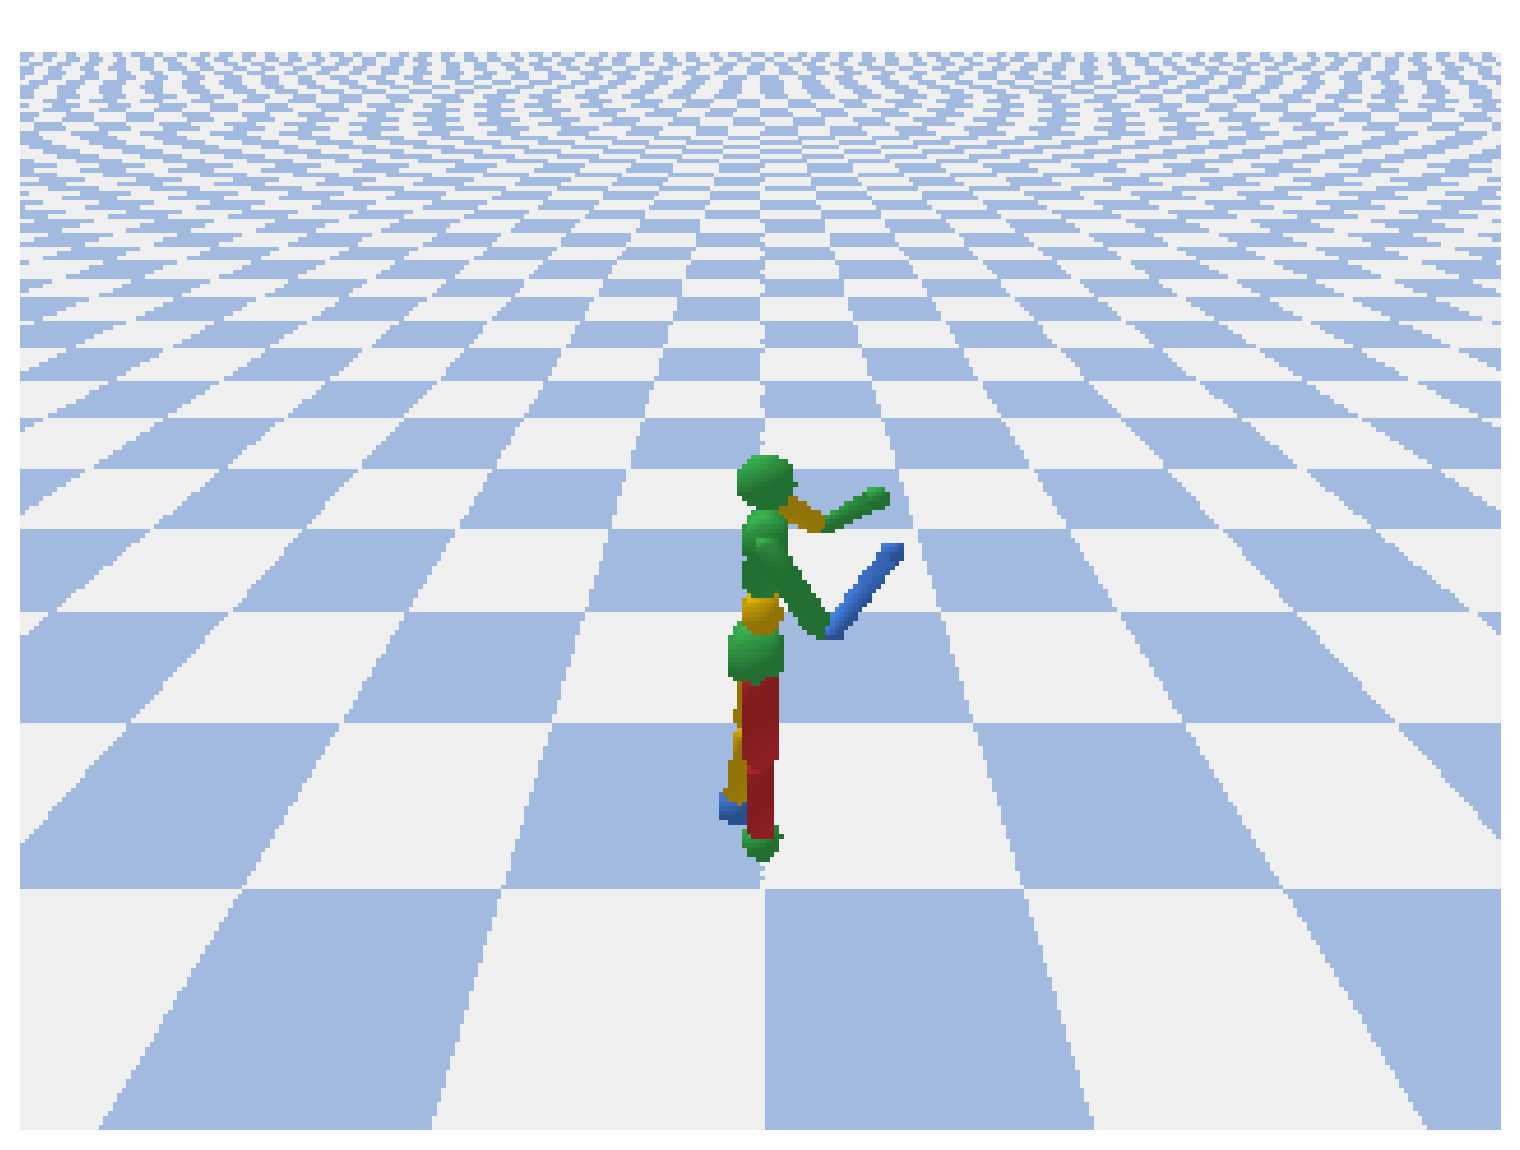

In [ ]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [ ]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  print('Actions:\n', action)

  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

Actions:
 [-0.11859202  0.84151515  0.19242498  0.87913033  0.42002968  0.35313023
  0.93552228 -0.51018236  0.32892366  0.51606513  0.16412751 -0.14327158
 -0.1073768  -0.44934326 -0.90531823  0.37327511 -0.31439877]
Actions:
 [-0.96546081 -0.68321345  0.41909669  0.4353791   0.10027969 -0.49342999
  0.75297581  0.01201646  0.46236082  0.95161469  0.35551544  0.19429106
 -0.85631574  0.92528956 -0.94474459  0.43078375  0.86138322]
Actions:
 [ 0.36176045  0.40311212  0.01671752  0.47477455 -0.90243604 -0.63209326
  0.71963931  0.78007069 -0.54492334  0.24109258  0.21160988 -0.63881903
 -0.75589869  0.00762029 -0.1578871   0.30643034  0.93812207]
Actions:
 [ 0.95131611  0.96039576  0.10601529  0.47095328  0.46543812  0.08158498
  0.7942633  -0.47052225  0.18499911 -0.71643961 -0.14974124  0.00356604
  0.68760779  0.08540555  0.54512139 -0.6449008   0.26255666]
Actions:
 [ 0.31578756 -0.1314897  -0.44054076 -0.18588445 -0.21045415 -0.39733856
  0.09851588  0.08471725  0.74056329 -0.54297

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(17,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])
Observations:
 BoundedArray(shape=(44,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [-1.62657163e-02  3.24153492e-04  1.31815581e+00]
torso      [-1.35373968e-02 -8.40210207e-05  1.39134872e+00]
link0_3    [-1.62657163e-02  3.24153492e-04  1.31815581e+00]
lwaist     [-3.47488556e-03 -1.02115720e-03  1.25444094e+00]
link0_5    [ 0.00892641 -0.0023232   1.19064613]
pelvis     [ 0.00929961 -0.0042727   1.08868506]
link0_7    [ 0.02528803 -0.10740856  1.05540795]
link0_8    [ 0.02528803 -0.10740856  1.05540795]
link0_9    [ 0.02528803 -0.10740856  1.05540795]
right_thigh [ 0.0286661  -0.12735016  0.88654137]
link0_11   [ 0.03303314 -0.15357936  0.67514848]
right_shin [ 0.03367537 -0.17878958  0.50702937]
right_foot [ 0.03480871 -0.22327821  0.21034862]
link0_14   [0.04812263 0.09124889 1.05169319]
link0_15   [0.04812263 0.09124889 1.05169319]
link0_16   [0.04812263 0.09124889 1.05169319]
left_thigh [0.04429264 0.06849377 0.88319234]
link0_18   [0.03964787 0.041231   0.67193618]
left_shin  [0.03737417 0.02329288 0.50290052]
left_foot  [ 0.03336175 -0.00836262  0

In [ ]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([-0.32638688,  0.01364326, -0.41111357])

First, lets configure loggers and optimizers:

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

---
# DDPG agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

[Learner] Critic Loss = 5.013 | Policy Loss = 0.500 | Steps = 537 | Walltime = 47.590
[Environment Loop] Episode Length = 17 | Episode Return = -74.32935333251953 | Episodes = 272 | Steps = 5296 | Steps Per Second = 88.248
[Learner] Critic Loss = 15.798 | Policy Loss = 0.500 | Steps = 1308 | Walltime = 107.603
[Environment Loop] Episode Length = 36 | Episode Return = -13.589775085449219 | Episodes = 520 | Steps = 11493 | Steps Per Second = 109.653
[Learner] Critic Loss = 13.703 | Policy Loss = 0.500 | Steps = 2085 | Walltime = 167.701
[Environment Loop] Episode Length = 46 | Episode Return = 25.101238250732422 | Episodes = 673 | Steps = 17733 | Steps Per Second = 71.019
[Learner] Critic Loss = 10.221 | Policy Loss = 0.500 | Steps = 2883 | Walltime = 227.743
[Environment Loop] Episode Length = 37 | Episode Return = -4.966611862182617 | Episodes = 812 | Steps = 24166 | Steps Per Second = 122.597
[Learner] Critic Loss = 10.625 | Policy Loss = 0.500 | Steps = 3668 | Walltime = 287.747
[Env

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 1000

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Plot the reward

Each color represent a separate episode.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


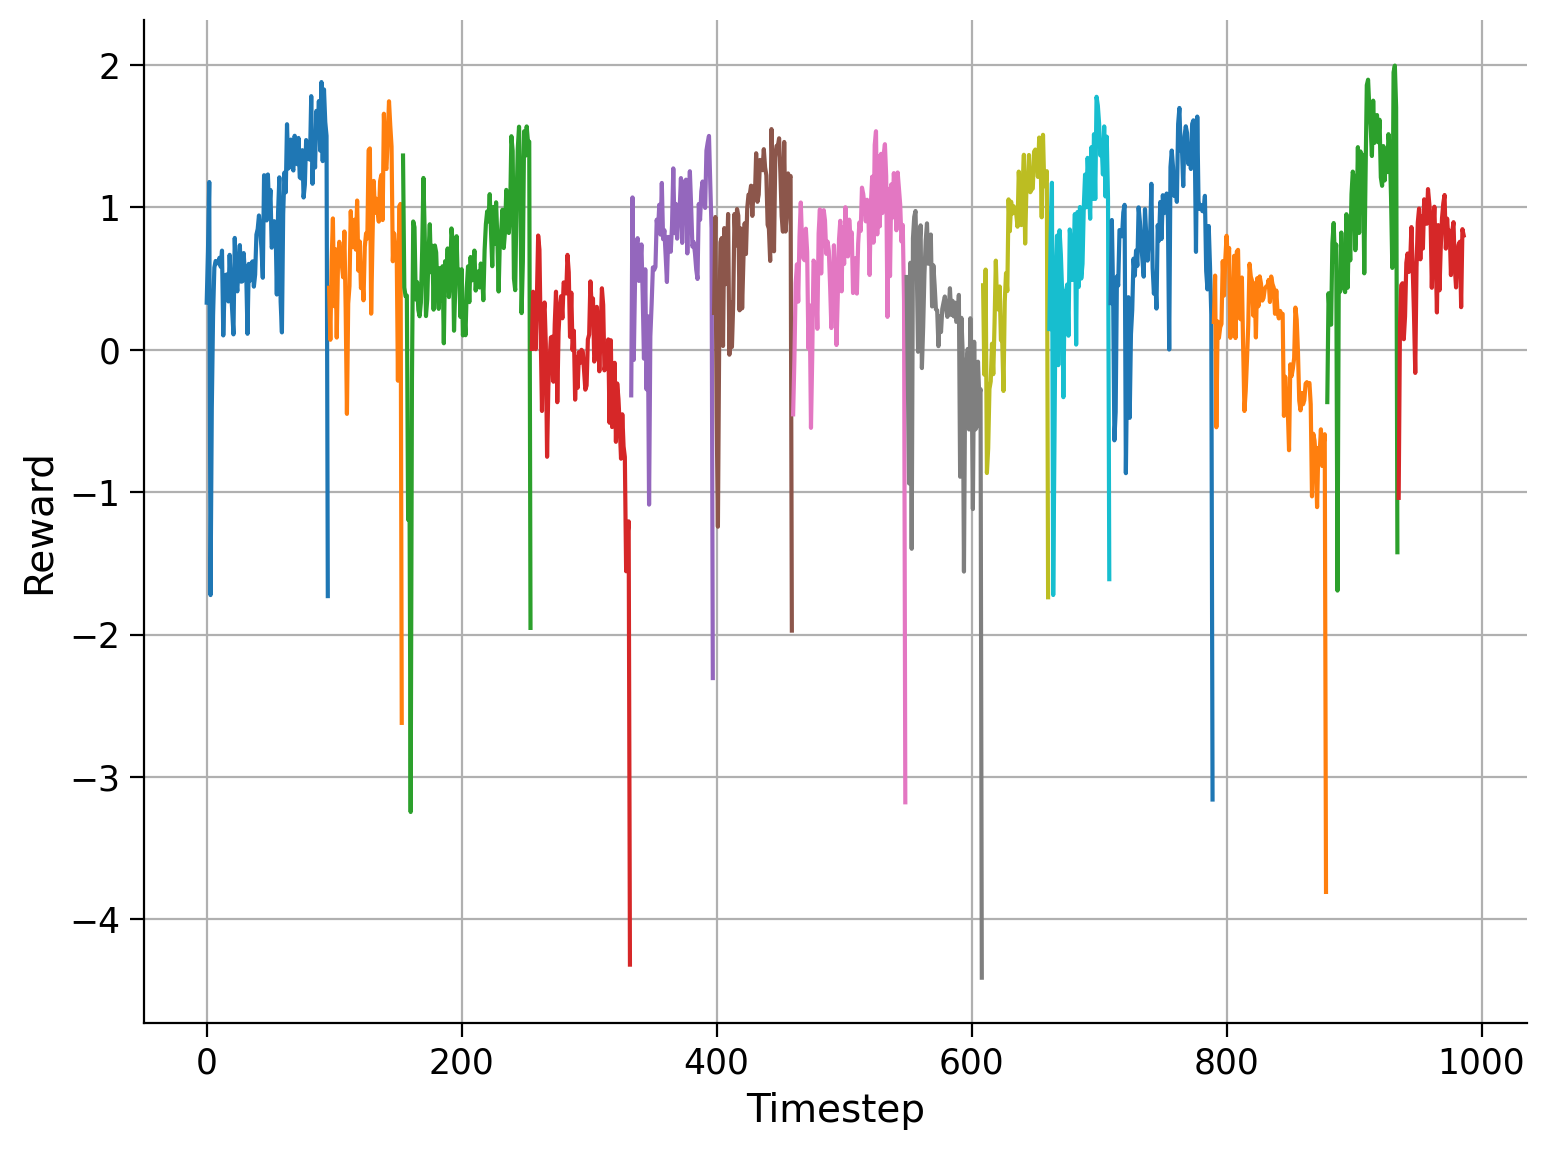

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

## Total reward

Finally, let's print the total reward for the test episodes

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

Total reward in episode 0: 82.20
Total reward in episode 1: 42.64
Total reward in episode 2: 59.17
Total reward in episode 3: -7.59
Total reward in episode 4: 45.89
Total reward in episode 5: 50.17
Total reward in episode 6: 62.19
Total reward in episode 7: 3.91
Total reward in episode 8: 35.33
Total reward in episode 9: 35.64
Total reward in episode 10: 62.78
Total reward in episode 11: 1.00
Total reward in episode 12: 55.05
Total reward in episode 13: 33.92


### 1. Mount drive to temporarily save checkpoints

In [ ]:
# Mount drive. -- You may want to add your gDrive
# drive.mount('/root/drive')

### 2. BEFORE restarting the runtime, save checkpoint to drive

In [ ]:
# Save agent checkpoint to drive.
save_ckpt_to_drive(agent)

Saved /root/acme/4c7467de-9cdf-11ee-b6f1-0242ac1c000c/checkpoints/default to /root/drive/MyDrive/acme_ckpt


### 3. AFTER restarting the runtime, restore checkpoint from drive

To restore a checkpoint in the restarted Colab runtime:

1.   Re-install all the libraries and run all the cells as before, including the agent instantiation, **except** the training cell.
2.   Run the cell below.
3.   Run the cell that instantiates the agent **again**.

In [ ]:
# Restore checkpoint from drive.
restore_ckpt_from_drive(agent)

Restored /root/acme/4c7467de-9cdf-11ee-b6f1-0242ac1c000c/checkpoints/default from /root/drive/MyDrive/acme_ckpt


### 4. Optionally, unmount drive

In [ ]:
# Unmount drive.
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.
